<h1>Sentiment analysis using Distilroberta and SHAP</h1>
<p>Additionally investigate potential for price prediction

In [59]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns

from transformers import pipeline

import cleaned dataset and analyze initial file characteristics

In [60]:
df = pd.read_csv('data/finance_stocks/finance_stocks-train-cleaned.csv')
print('Dataset size:',df.shape)
print('Dataset columns:',df.columns)
df.info()
df.head()

Dataset size: (22383, 11)
Dataset columns: Index(['timestamp', 'tweet_text', 'tweet_url', 'tweet_type', 'price_of_ticker',
       'change_of_ticker', 'tickers_mentioned', 'category', 'clean_tweet_text',
       'Tweet_lemmatized', 'stemmed_text'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22383 entries, 0 to 22382
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   timestamp          14363 non-null  object
 1   tweet_text         20899 non-null  object
 2   tweet_url          22383 non-null  object
 3   tweet_type         22383 non-null  object
 4   price_of_ticker    22383 non-null  object
 5   change_of_ticker   22383 non-null  object
 6   tickers_mentioned  22383 non-null  object
 7   category           22383 non-null  object
 8   clean_tweet_text   20895 non-null  object
 9   Tweet_lemmatized   22383 non-null  object
 10  stemmed_text       20895 non-null  object
dtypes: obj

,timestamp,tweet_text,tweet_url,tweet_type,price_of_ticker,change_of_ticker,tickers_mentioned,category,clean_tweet_text,Tweet_lemmatized,stemmed_text
0,2023-11-15T09:36:42.028000+00:00,$GOLD's Massive Range.\n\nIn the past ~year we...,https://twitter.com/user/status/17247221551437...,tweet,['15.71'],['+3.69%'],['$GOLD'],stock_images,golds massive range past year weve swept lows ...,"['g', 'o', 'l', 'd', 's', ' ', 'm', 'a', 's', ...",gold massiv rang past year weve swept low high...
1,2023-11-15T06:01:59.788000+00:00,RT @SmartReversals: $SPX - Daily Chart:\n\n✅Ta...,https://twitter.com/user/status/17246687922221...,retweet,['4495.71'],['+1.87%'],['$SPX'],stock_images,rt spx daily chart target bull move mentioned ...,"['r', 't', ' ', 's', 'p', 'x', ' ', 'd', 'a', ...",rt spx daili chart target bull move mention be...
2,2023-11-15T06:01:55.590000+00:00,RT @SmartReversals: $NDX - Daily Chart:\n\n✅Ta...,https://twitter.com/user/status/17246687824535...,retweet,['15812.473'],['+2.08%'],['$NDX'],stock_images,rt ndx daily chart target bull move mentioned ...,"['r', 't', ' ', 'n', 'd', 'x', ' ', 'd', 'a', ...",rt ndx daili chart target bull move mention be...
3,2023-11-15T06:01:51.329000+00:00,RT @SmartReversals: $IWM - Daily Chart:\n\n✅Ta...,https://twitter.com/user/status/17246687591081...,retweet,['178.46'],['+5.21%'],['$IWM'],stock_images,rt iwm daily chart target bull move mentioned ...,"['r', 't', ' ', 'i', 'w', 'm', ' ', 'd', 'a', ...",rt iwm daili chart target bull move mention la...
4,2023-11-15T04:01:49.009000+00:00,RT @coiledspringcap: Everyone has been concern...,https://twitter.com/user/status/17246376898767...,retweet,['4495.71'],['+1.87%'],['$SPX'],stock_images,rt everyone concerned concentration stockmarke...,"['r', 't', ' ', 'e', 'v', 'e', 'r', 'y', 'o', ...",rt everyon concern concentr stockmarket well n...


Apply further data processesing to enhance efficienccy for SHAP evaluation and price prediction model

In [61]:
df['change_of_ticker'] = df['change_of_ticker'].str.extract(r'([-+]?\d+\.\d+|\d+)')
df['price_of_ticker'] = df['price_of_ticker'].str.extract(r'([-+]?\d+\.\d+|\d+)')
df['tickers_mentioned'] = df['tickers_mentioned'].str.extract(r'(\$[A-Za-z]+)')
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed')
df = df.sort_values(by='timestamp')
df = df.reset_index(drop=True)
df = df[['timestamp', 'clean_tweet_text', 'tweet_type', 'price_of_ticker', 'change_of_ticker', 'tickers_mentioned']]
df = df.dropna()
df.head()

,timestamp,clean_tweet_text,tweet_type,price_of_ticker,change_of_ticker,tickers_mentioned
0,2021-12-27 16:59:17.621000+00:00,rt teva c underlying diff bidask interest volu...,tweet,8.5,+0.47,$TEVA
1,2021-12-27 17:00:14.167000+00:00,rt teva c underlying diff bidask interest volu...,tweet,8.48,+0.3,$TEVA
2,2021-12-27 17:04:55.943000+00:00,teva c underlying diff bidask interest volume ...,tweet,8.49,+0.35,$TEVA
3,2021-12-27 17:09:47.125000+00:00,analyst rating upgrades h gt downgrades cvna g...,tweet,94.24,+0.66,$H
4,2021-12-27 17:19:22.613000+00:00,disca c underlying diff bidask interest volume...,tweet,24.41,-0.04,$DISCA


<h2>Applying finetuned distilroberta model for financial news sentiment anaylsis </h2>
<p>In order to increase the efficiency and processing duration a sample of random rows within the dataset is selected

In [62]:
stock = '$GOLD' 
df_filtered = df[(df['clean_tweet_text'].str.split().apply(len) > 6) &                     
                 (df['tickers_mentioned'] == stock)]

df_shap = df_filtered.sample(n=20, random_state=1)
df_shap.head()

,timestamp,clean_tweet_text,tweet_type,price_of_ticker,change_of_ticker,tickers_mentioned
10713,2023-04-04 14:17:31.918000+00:00,disbelief intensifies metals market gold nears...,tweet,19.33,+2.79,$GOLD
7557,2022-12-19 09:11:24.642000+00:00,gold way recover rounding bottom daily sr zone...,tweet,16.9,+1.48,$GOLD
7942,2023-01-05 13:09:33.466000+00:00,entered yesterday short already small profit l...,tweet,18.88,+5.56,$GOLD
11366,2023-05-07 10:45:27.967000+00:00,remainder may going amazing hard assets gold,tweet,20.2,-1.14,$GOLD
9601,2023-02-16 18:06:23.062000+00:00,gold strong h high volume mins close,tweet,17.04,-0.76,$GOLD


<h4>Testing the accuracy of the model on the trained dataset with 50% annotator agreement

In [63]:
from datasets import load_dataset
#https://huggingface.co/datasets/TimKoornstra/financial-tweets-sentiment/viewer
#https://huggingface.co/datasets/takala/financial_phrasebank#data-fields
ds = load_dataset("takala/financial_phrasebank", name="sentences_50agree")

In [64]:
df_train = ds['train'].to_pandas()
df_train

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,Technopolis plans to develop in stages an area...,1
2,The international electronic industry company ...,0
3,With the new production plant the company woul...,2
4,According to the company 's updated strategy f...,2
...,...,...
4841,LONDON MarketWatch -- Share prices ended lower...,0
4842,Rinkuskiai 's beer sales fell by 6.5 per cent ...,1
4843,Operating profit fell to EUR 35.4 mn from EUR ...,0
4844,Net sales of the Paper segment decreased to EU...,0


In [121]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=-1).item()
    return predicted_class_id

df_train['predicted_sentiment'] = df_train['sentence'].apply(predict_sentiment)

accuracy = (df_train['label'] == df_train['predicted_sentiment']).mean()

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.86


<h4>Applying the model on the new dataset

In [66]:
pipe = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

In [67]:
texts = df_shap["clean_tweet_text"].tolist()

predictions = []
scores = []

for text in texts:
    result = pipe(text)[0]  
    predictions.append(result['label'])
    scores.append(result['score'])

df_shap['Sentiment'] = predictions
df_shap['SentimentScore'] = scores

In [68]:
df_shap.head()

,timestamp,clean_tweet_text,tweet_type,price_of_ticker,change_of_ticker,tickers_mentioned,Sentiment,SentimentScore
10713,2023-04-04 14:17:31.918000+00:00,disbelief intensifies metals market gold nears...,tweet,19.33,+2.79,$GOLD,positive,0.999298
7557,2022-12-19 09:11:24.642000+00:00,gold way recover rounding bottom daily sr zone...,tweet,16.9,+1.48,$GOLD,positive,0.999523
7942,2023-01-05 13:09:33.466000+00:00,entered yesterday short already small profit l...,tweet,18.88,+5.56,$GOLD,negative,0.997884
11366,2023-05-07 10:45:27.967000+00:00,remainder may going amazing hard assets gold,tweet,20.2,-1.14,$GOLD,positive,0.659316
9601,2023-02-16 18:06:23.062000+00:00,gold strong h high volume mins close,tweet,17.04,-0.76,$GOLD,neutral,0.999613


In [69]:
df_shap.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 10713 to 8283
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   timestamp          20 non-null     datetime64[ns, UTC]
 1   clean_tweet_text   20 non-null     object             
 2   tweet_type         20 non-null     object             
 3   price_of_ticker    20 non-null     object             
 4   change_of_ticker   20 non-null     object             
 5   tickers_mentioned  20 non-null     object             
 6   Sentiment          20 non-null     object             
 7   SentimentScore     20 non-null     float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(6)
memory usage: 1.4+ KB


Visualizing predicted scores

/var/folders/t7/fsw9g80x43g_y23dd_1lqh9h0000gn/T/ipykernel_2905/2407733181.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


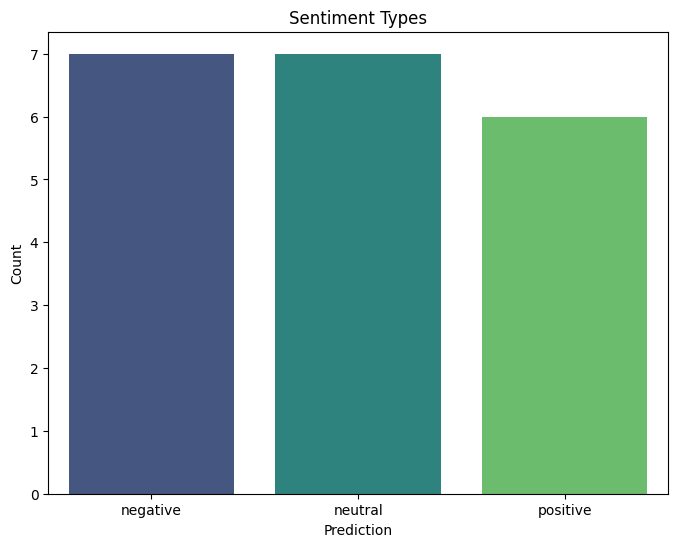

In [70]:
sentiment_counts = df_shap['Sentiment'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Types')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.show()

<h2>Applying SHAP</h2>

In [71]:
shap_text = df_shap['clean_tweet_text'].astype(str).tolist()

In [72]:
explainer = shap.Explainer(pipe)
shap_values = explainer(shap_text)

PartitionExplainer explainer: 21it [02:10,  6.52s/it]                        


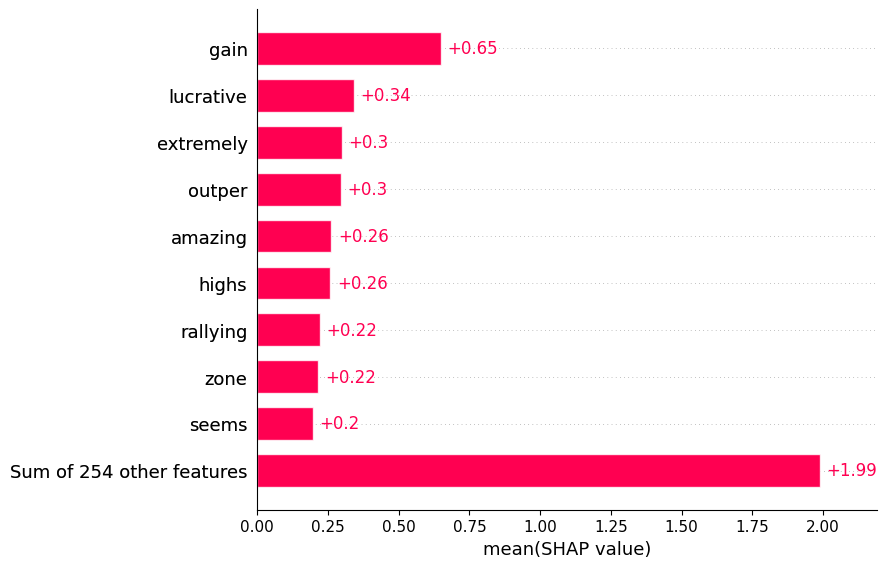

In [73]:
shap.plots.bar(shap_values[:, :, "positive"].mean(0))

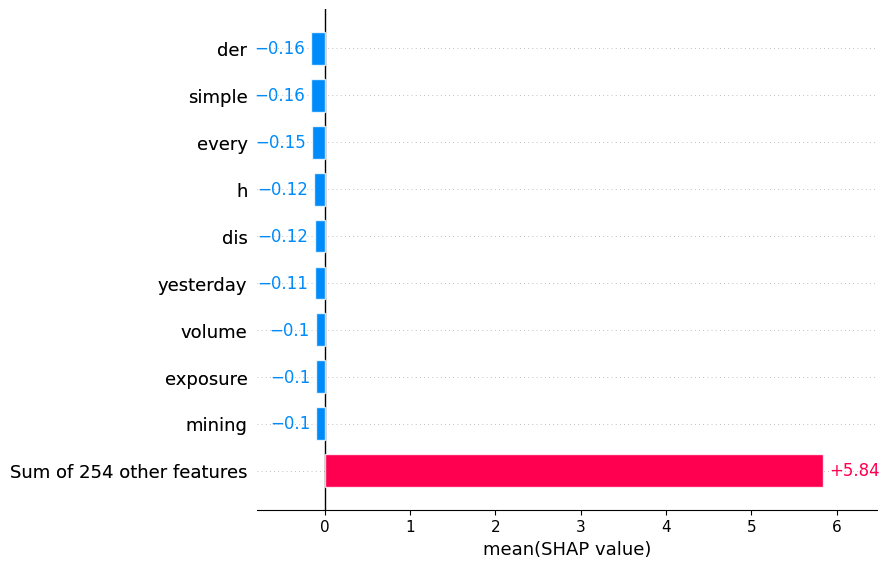

In [74]:
shap.plots.bar(shap_values[:, :, "positive"].mean(0), order=shap.Explanation.argsort)

In [75]:
shap.plots.text(shap_values[:, :, "positive"])

SHAP Result interpretation

<h2>Price prediction and SHAP analysis

Visualization for price prediction to identify less volatile stocks based on the price changes [change_of_ticker]

In [76]:
df['tickers_mentioned'].value_counts()

tickers_mentioned
$SPY     1209
$DXY      906
$SPX      660
$TSLA     589
$QQQ      488
         ... 
$VGFC       1
$CLX        1
$ECNS       1
$BP         1
$TNA        1
Name: count, Length: 1377, dtype: int64

In [77]:
tickers_of_interest = ['$SPX', '$DXY', '$SPY']
filtered_df_plot = df[df['tickers_mentioned'].isin(tickers_of_interest)]
filtered_df_plot = filtered_df_plot.copy()
filtered_df_plot.loc[:, 'change_of_ticker'] = filtered_df_plot['change_of_ticker'].str.replace('+', '').astype(float)
filtered_df_plot.set_index('timestamp', inplace=True)


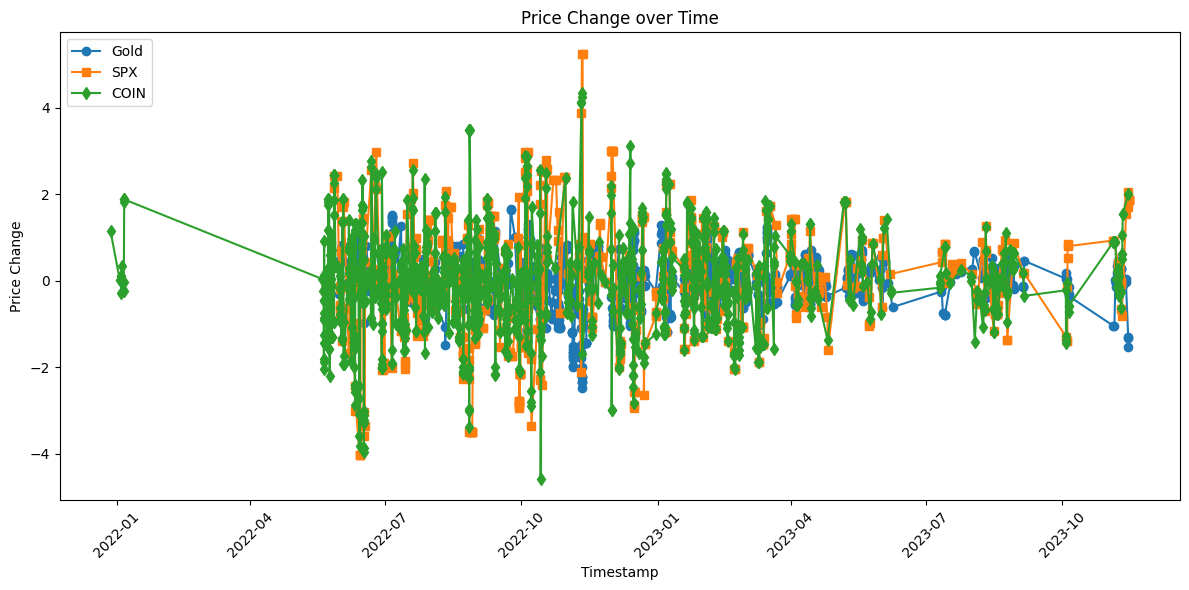

In [78]:
DXY = filtered_df_plot['tickers_mentioned'] == '$DXY'
spx = filtered_df_plot['tickers_mentioned'] == '$SPX'
SPY = filtered_df_plot['tickers_mentioned'] == '$SPY'

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(filtered_df_plot[DXY]["change_of_ticker"], marker='o', linestyle='-', label='Gold')
plt.plot(filtered_df_plot[spx]["change_of_ticker"], marker='s', linestyle='-', label='SPX')
plt.plot(filtered_df_plot[SPY]["change_of_ticker"], marker='d', linestyle='-', label='COIN')

plt.title('Price Change over Time')
plt.ylabel('Price Change')
plt.xlabel('Timestamp')
plt.legend(loc='upper left')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

 Simple LSTM (Long Short-Term Memory) model for predicting stock prices

In [79]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import MinMaxScaler
from transformers import pipeline

Defining dataframe for prediction including the sentiment analysis of the model to analyze the correlation and results

In [80]:
df_pred_model = df

In [81]:
df_pred = df_pred_model[df_pred_model['tickers_mentioned'] == '$SPX']
df_pred.head()

,timestamp,clean_tweet_text,tweet_type,price_of_ticker,change_of_ticker,tickers_mentioned
890,2022-05-27 19:44:22.298000+00:00,spx monthly green correlation back please,tweet,4147.11,+2.15,$SPX
894,2022-05-27 21:01:07.205000+00:00,spx erased weeks downtrend last days swing low...,tweet,4158.23,+2.41,$SPX
912,2022-05-29 18:46:20.003000+00:00,happens impossible american economy allows go ...,tweet,4158.23,+2.41,$SPX
935,2022-05-31 14:26:21.824000+00:00,possible consolidation spx daily run last week...,tweet,4124.35,-0.82,$SPX
952,2022-05-31 15:57:38.201000+00:00,spx plan still stands upper red box reversal l...,tweet,4149.79,-0.2,$SPX


In [82]:
text_p = df_pred["clean_tweet_text"].tolist()

predictions_p = []
scores_p = []

for text in text_p:
    result_p = pipe(text)[0]  
    predictions_p.append(result_p['label'])
    scores_p.append(result_p['score'])

df_pred['Sentiment'] = predictions_p
df_pred['SentimentScore'] = scores_p

/var/folders/t7/fsw9g80x43g_y23dd_1lqh9h0000gn/T/ipykernel_2905/238542847.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['Sentiment'] = predictions_p
/var/folders/t7/fsw9g80x43g_y23dd_1lqh9h0000gn/T/ipykernel_2905/238542847.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['SentimentScore'] = scores_p


In [83]:
df_pred.head()

,timestamp,clean_tweet_text,tweet_type,price_of_ticker,change_of_ticker,tickers_mentioned,Sentiment,SentimentScore
890,2022-05-27 19:44:22.298000+00:00,spx monthly green correlation back please,tweet,4147.11,+2.15,$SPX,neutral,0.999736
894,2022-05-27 21:01:07.205000+00:00,spx erased weeks downtrend last days swing low...,tweet,4158.23,+2.41,$SPX,negative,0.997853
912,2022-05-29 18:46:20.003000+00:00,happens impossible american economy allows go ...,tweet,4158.23,+2.41,$SPX,negative,0.548929
935,2022-05-31 14:26:21.824000+00:00,possible consolidation spx daily run last week...,tweet,4124.35,-0.82,$SPX,negative,0.712242
952,2022-05-31 15:57:38.201000+00:00,spx plan still stands upper red box reversal l...,tweet,4149.79,-0.2,$SPX,positive,0.991341


In [84]:
df_pred['Sentiment_numeric'] = df_pred['Sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})


/var/folders/t7/fsw9g80x43g_y23dd_1lqh9h0000gn/T/ipykernel_2905/1011016249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['Sentiment_numeric'] = df_pred['Sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})


In [85]:
print(df_pred.isnull().sum())
#df_pred = df_pred.dropna()
df_pred.head()

timestamp            0
clean_tweet_text     0
tweet_type           0
price_of_ticker      0
change_of_ticker     0
tickers_mentioned    0
Sentiment            0
SentimentScore       0
Sentiment_numeric    0
dtype: int64


,timestamp,clean_tweet_text,tweet_type,price_of_ticker,change_of_ticker,tickers_mentioned,Sentiment,SentimentScore,Sentiment_numeric
890,2022-05-27 19:44:22.298000+00:00,spx monthly green correlation back please,tweet,4147.11,+2.15,$SPX,neutral,0.999736,0
894,2022-05-27 21:01:07.205000+00:00,spx erased weeks downtrend last days swing low...,tweet,4158.23,+2.41,$SPX,negative,0.997853,-1
912,2022-05-29 18:46:20.003000+00:00,happens impossible american economy allows go ...,tweet,4158.23,+2.41,$SPX,negative,0.548929,-1
935,2022-05-31 14:26:21.824000+00:00,possible consolidation spx daily run last week...,tweet,4124.35,-0.82,$SPX,negative,0.712242,-1
952,2022-05-31 15:57:38.201000+00:00,spx plan still stands upper red box reversal l...,tweet,4149.79,-0.2,$SPX,positive,0.991341,1


In [86]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import shap
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df_pred['clean_tweet_text'])
y = df_pred['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_array = X_train.toarray()
X_test_array = X_test.toarray()

svm = SVC(kernel='linear')
svm.fit(X_train_array, y_train)
y_pred = svm.predict(X_test_array)

#clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7424242424242424
Classification Report:
              precision    recall  f1-score   support

    negative       0.76      0.63      0.69        30
     neutral       0.76      0.93      0.84        69
    positive       0.65      0.45      0.54        33

    accuracy                           0.74       132
   macro avg       0.72      0.67      0.69       132
weighted avg       0.73      0.74      0.73       132



In [87]:
df_pred.loc[:, 'change_of_ticker_increases']= df['change_of_ticker'].str.startswith('+').replace({True: '1', False: '0'})
df_pred.loc[:, 'predict'] = df['price_of_ticker'].astype(float) + df['change_of_ticker'].astype(float)

/var/folders/t7/fsw9g80x43g_y23dd_1lqh9h0000gn/T/ipykernel_2905/76894039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred.loc[:, 'change_of_ticker_increases']= df['change_of_ticker'].str.startswith('+').replace({True: '1', False: '0'})
/var/folders/t7/fsw9g80x43g_y23dd_1lqh9h0000gn/T/ipykernel_2905/76894039.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred.loc[:, 'predict'] = df['price_of_ticker'].astype(float) + df['change_of_ticker'].astype(float)


In [88]:
df_pred.head()

,timestamp,clean_tweet_text,tweet_type,price_of_ticker,change_of_ticker,tickers_mentioned,Sentiment,SentimentScore,Sentiment_numeric,change_of_ticker_increases,predict
890,2022-05-27 19:44:22.298000+00:00,spx monthly green correlation back please,tweet,4147.11,+2.15,$SPX,neutral,0.999736,0,1,4149.26
894,2022-05-27 21:01:07.205000+00:00,spx erased weeks downtrend last days swing low...,tweet,4158.23,+2.41,$SPX,negative,0.997853,-1,1,4160.64
912,2022-05-29 18:46:20.003000+00:00,happens impossible american economy allows go ...,tweet,4158.23,+2.41,$SPX,negative,0.548929,-1,1,4160.64
935,2022-05-31 14:26:21.824000+00:00,possible consolidation spx daily run last week...,tweet,4124.35,-0.82,$SPX,negative,0.712242,-1,0,4123.53
952,2022-05-31 15:57:38.201000+00:00,spx plan still stands upper red box reversal l...,tweet,4149.79,-0.2,$SPX,positive,0.991341,1,0,4149.59


In [89]:
#Define new dataframe by droping not required columns
df_price_p = df_pred[['timestamp','change_of_ticker', 'SentimentScore', 'predict']]

In [90]:
df_price_p.head()

,timestamp,change_of_ticker,SentimentScore,predict
890,2022-05-27 19:44:22.298000+00:00,+2.15,0.999736,4149.26
894,2022-05-27 21:01:07.205000+00:00,+2.41,0.997853,4160.64
912,2022-05-29 18:46:20.003000+00:00,+2.41,0.548929,4160.64
935,2022-05-31 14:26:21.824000+00:00,-0.82,0.712242,4123.53
952,2022-05-31 15:57:38.201000+00:00,-0.2,0.991341,4149.59


In [91]:
df_price_p.corr()

,timestamp,change_of_ticker,SentimentScore,predict
timestamp,1.000000,0.112413,0.052621,0.523080
change_of_ticker,0.112413,1.000000,0.061738,0.204224
SentimentScore,0.052621,0.061738,1.000000,0.062869
predict,0.523080,0.204224,0.062869,1.000000


/var/folders/t7/fsw9g80x43g_y23dd_1lqh9h0000gn/T/ipykernel_2905/930295350.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price_p['predict'] = df_price_p['predict'].astype(float)


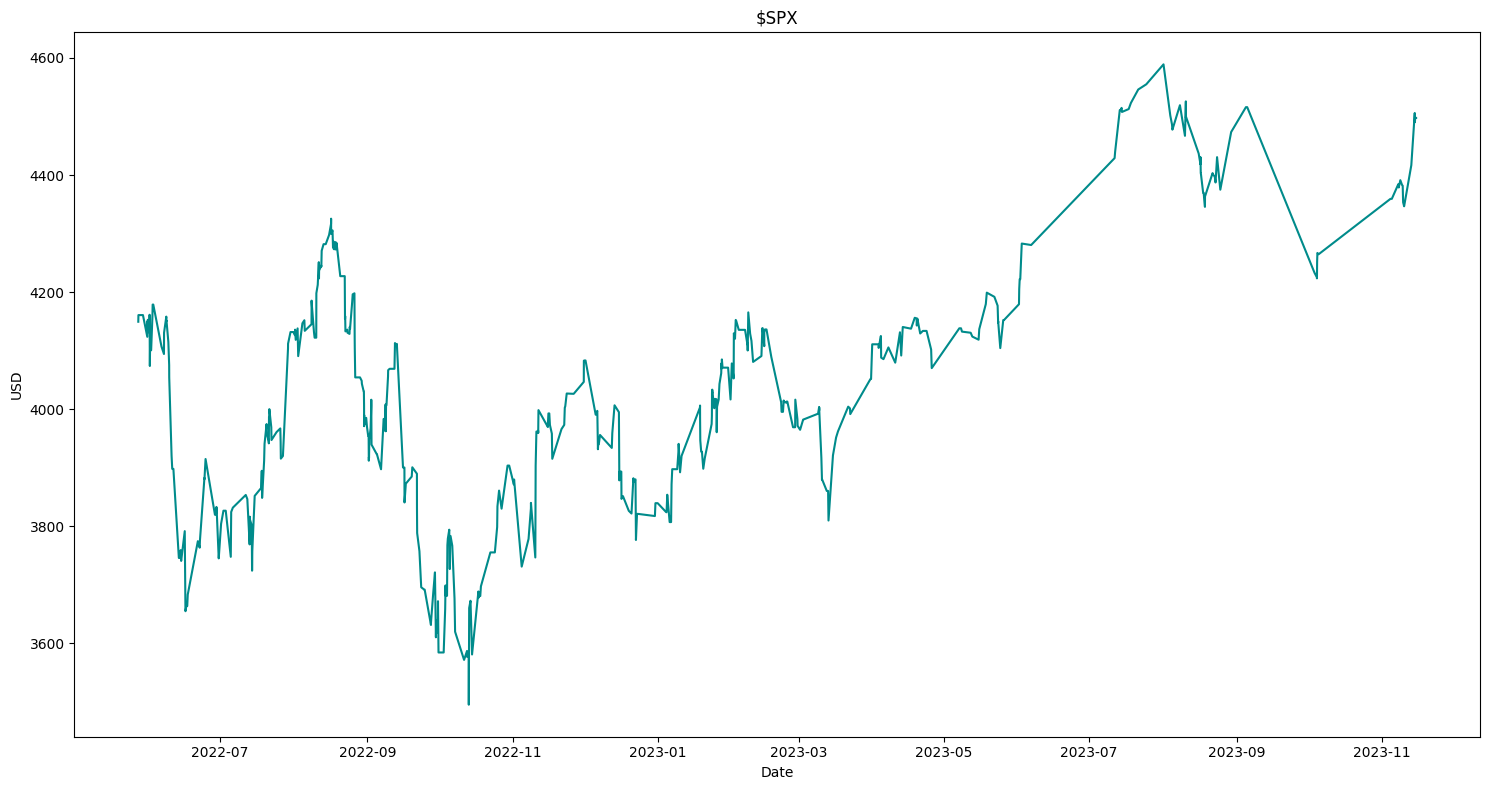

In [92]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter  # Import DateFormatter
df_price_p['predict'] = df_price_p['predict'].astype(float)

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df_price_p['timestamp'], df_price_p['predict'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title='$SPX')
plt.tight_layout()
plt.show()

In [93]:
def get_tech_ind(data):
    data['MA7'] = data['predict'].rolling(window=7).mean()  # 7-day moving average
    data['MA20'] = data['predict'].rolling(window=20).mean()  # 20-day moving average

    data['MACD'] = data['predict'].ewm(span=12, adjust=False).mean() - data['predict'].ewm(span=26, adjust=False).mean()
    # MACD: 12-day EMA minus 26-day EMA of price_of_ticker

    # Create Bollinger Bands
    data['20SD'] = data['predict'].rolling(20).std()  # 20-day rolling standard deviation
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)  # Upper Bollinger Band
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)  # Lower Bollinger Band

    # Create Exponential Moving Average (EMA)
    data['EMA'] = data['predict'].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data['predict'] / data['predict'].shift(1))

    return data

In [94]:
tech_df = get_tech_ind(df_price_p)
dataset = tech_df.iloc[20:, :].reset_index(drop=True)
dataset.head()

/var/folders/t7/fsw9g80x43g_y23dd_1lqh9h0000gn/T/ipykernel_2905/1554240884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA7'] = data['predict'].rolling(window=7).mean()  # 7-day moving average
/var/folders/t7/fsw9g80x43g_y23dd_1lqh9h0000gn/T/ipykernel_2905/1554240884.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA20'] = data['predict'].rolling(window=20).mean()  # 20-day moving average
/var/folders/t7/fsw9g80x43g_y23dd_1lqh9h0000gn/T/ipykernel_2905/1554240884.py:5: SettingWithCopyW

,timestamp,change_of_ticker,SentimentScore,predict,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2022-06-02 05:12:22.603000+00:00,-0.75,0.998293,4100.49,4100.895714,4123.5805,-12.168840,25.499646,4174.579792,4072.581208,4101.146204,0.000000
1,2022-06-02 18:21:54.564000+00:00,+1.38,0.999892,4160.15,4113.251429,4123.5560,-7.339671,25.462373,4174.480747,4072.631253,4140.482068,0.014445
2,2022-06-02 19:54:45.563000+00:00,+1.71,0.999879,4174.20,4123.862857,4124.2340,-2.351694,26.654431,4177.542861,4070.925139,4162.960689,0.003372
3,2022-06-02 20:05:39.056000+00:00,+1.81,0.999883,4178.62,4134.455714,4126.9885,1.935658,29.293713,4185.575926,4068.401074,4173.400230,0.001058
4,2022-06-02 20:22:40.510000+00:00,+1.81,0.997057,4178.62,4141.865714,4128.4400,5.272636,31.133970,4190.707940,4066.172060,4176.880077,0.000000


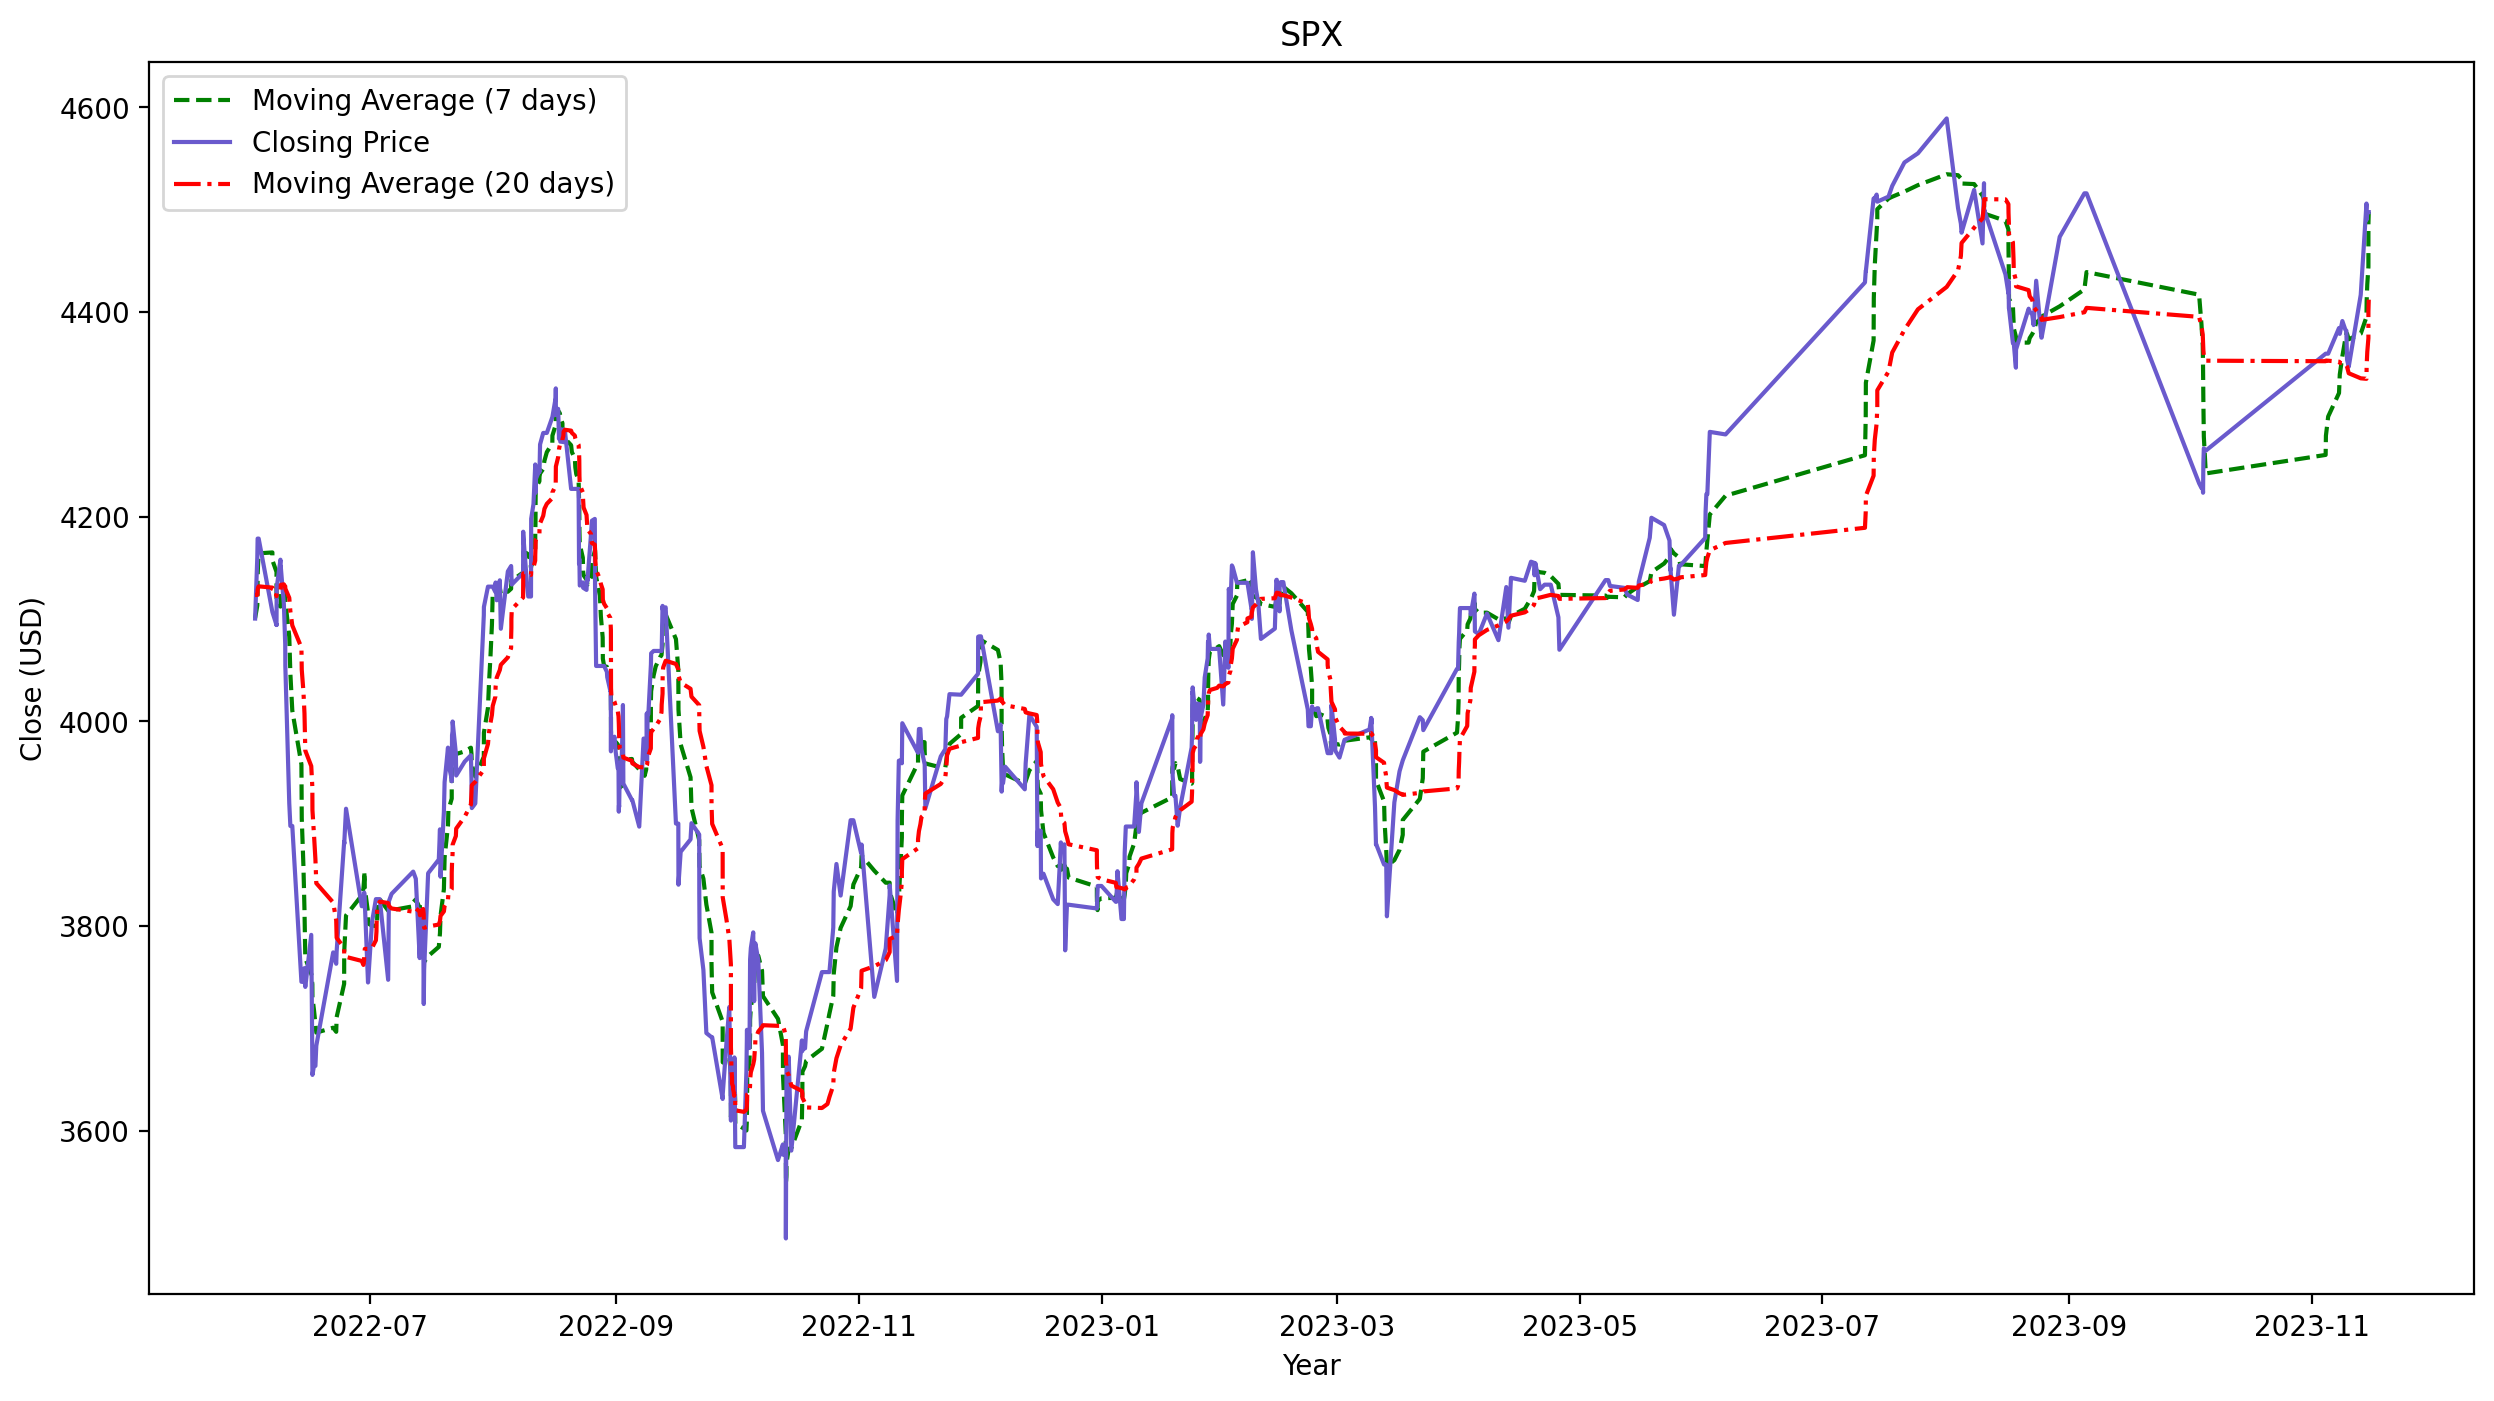

In [95]:

    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['timestamp'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['timestamp'], dataset['predict'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['timestamp'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    plt.title('SPX')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()

In [96]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

In [97]:
datetime_series = pd.to_datetime(dataset['timestamp'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='timestamp')
dataset = dataset.drop(columns='timestamp')

In [98]:
dataset.head()

,change_of_ticker,SentimentScore,predict,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
2022-06-02 05:12:22.603,-0.75,0.998293,4100.49,4100.895714,4123.5805,-12.168840,25.499646,4174.579792,4072.581208,4101.146204,0.000000
2022-06-02 18:21:54.564,+1.38,0.999892,4160.15,4113.251429,4123.5560,-7.339671,25.462373,4174.480747,4072.631253,4140.482068,0.014445
2022-06-02 19:54:45.563,+1.71,0.999879,4174.20,4123.862857,4124.2340,-2.351694,26.654431,4177.542861,4070.925139,4162.960689,0.003372
2022-06-02 20:05:39.056,+1.81,0.999883,4178.62,4134.455714,4126.9885,1.935658,29.293713,4185.575926,4068.401074,4173.400230,0.001058
2022-06-02 20:22:40.510,+1.81,0.997057,4178.62,4141.865714,4128.4400,5.272636,31.133970,4190.707940,4066.172060,4176.880077,0.000000


In [99]:
def normalize_data(df, range, target_column):

    '''
    df: dataframe object
    range: type tuple -> (lower_bound, upper_bound)
        lower_bound: int
        upper_bound: int
    target_column: type str -> should reflect closing price of stock
    '''

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)
    
    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

In [100]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()
    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)
    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [101]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [102]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [103]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import warnings
warnings.filterwarnings("ignore")

In [104]:
dataset.head()

,change_of_ticker,SentimentScore,predict,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
2022-06-02 05:12:22.603,-0.75,0.998293,4100.49,4100.895714,4123.5805,-12.168840,25.499646,4174.579792,4072.581208,4101.146204,0.000000
2022-06-02 18:21:54.564,+1.38,0.999892,4160.15,4113.251429,4123.5560,-7.339671,25.462373,4174.480747,4072.631253,4140.482068,0.014445
2022-06-02 19:54:45.563,+1.71,0.999879,4174.20,4123.862857,4124.2340,-2.351694,26.654431,4177.542861,4070.925139,4162.960689,0.003372
2022-06-02 20:05:39.056,+1.81,0.999883,4178.62,4134.455714,4126.9885,1.935658,29.293713,4185.575926,4068.401074,4173.400230,0.001058
2022-06-02 20:22:40.510,+1.81,0.997057,4178.62,4141.865714,4128.4400,5.272636,31.133970,4190.707940,4066.172060,4176.880077,0.000000


In [105]:
from sklearn.preprocessing import MinMaxScaler
import pickle  # Import the pickle module

X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "predict")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

X shape: (635, 5, 11)
y shape: (635, 1)
yc shape: (635, 5, 1)


In [106]:
input_dim = X_train.shape[1] 
feature_size = X_train.shape[2] 
output_dim = y_train.shape[1]

In [107]:
def make_generator_model(input_dim, output_dim, feature_size):
    model = tf.keras.Sequential([LSTM(units = 1024, return_sequences = True, 
                                    input_shape=(input_dim, feature_size),recurrent_dropout = 0.3),
                               LSTM(units = 512, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 256, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 64, recurrent_dropout = 0.3),
                               Dense(32),
                               Dense(16),
                               Dense(8),
                               Dense(units=output_dim)])
    return model

In [108]:
def make_discriminator_model(input_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(8, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    #cnn_net.add(Flatten())
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

In [109]:
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss

In [110]:
@tf.function

def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}

In [111]:
def train(real_x, real_y, yc, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint = 50):
    train_info = {}
    train_info["discriminator_loss"] = []
    train_info["generator_loss"] = []

    for epoch in tqdm(range(Epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        G_losses = []
        D_losses = []
        Real_price = []
        Predicted_price = []
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())
        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price.numpy())

        #Save model every X checkpoints
        if (epoch + 1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan//generator_V_%d.h5' % epoch)
            tf.keras.models.save_model(discriminator, f'./models_gan//discriminator_V_%d.h5' % epoch)
            print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())
    
        train_info["discriminator_loss"].append(D_losses)
        train_info["generator_loss"].append(G_losses)
  
    Predicted_price = np.array(Predicted_price)
    Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
    Real_price = np.array(Real_price)
    Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

    plt.subplot(2,1,1)
    plt.plot(train_info["discriminator_loss"], label='Disc_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator Loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(train_info["generator_loss"], label='Gen_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.legend()

    plt.show()

    return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

In [112]:
def plot_results(Real_price, Predicted_price, index_train):
    X_scaler = load(open('/content/X_scaler.pkl', 'rb'))
    y_scaler = load(open('/content/y_scaler.pkl', 'rb'))
    train_predict_index = index_train

    rescaled_Real_price = y_scaler.inverse_transform(Real_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
  
    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)
  
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color = 'r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Train RMSE -- ', RMSE)

In [113]:
## Test Code

@tf.function 

def eval_op(generator, real_x):
    generated_data = generator(real_x, training = False)

    return generated_data

In [114]:
def plot_test_data(Real_test_price, Predicted_test_price, index_test):
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = index_test

    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
  
    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)
  
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE: ', RMSE)
    
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Prediction on test data for ", fontsize=20)
    plt.show()

In [115]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [116]:
import tensorflow as tf

learning_rate = 5e-4
epochs = 300

# Use 'learning_rate' instead of 'lr'
g_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Assuming make_generator_model and other necessary code is defined
generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model(X_train.shape[1])


 17%|█▋        | 50/300 [00:34<02:31,  1.65it/s]

epoch 50 discriminator_loss 1.4025664 generator_loss 0.6822668


 33%|███▎      | 100/300 [01:03<01:56,  1.71it/s]

epoch 100 discriminator_loss 1.3877797 generator_loss 0.6895784


 50%|█████     | 150/300 [01:31<01:25,  1.75it/s]

epoch 150 discriminator_loss 1.3900565 generator_loss 0.69102407


 67%|██████▋   | 200/300 [01:59<00:56,  1.76it/s]

epoch 200 discriminator_loss 1.378376 generator_loss 0.7015949


 83%|████████▎ | 250/300 [02:29<00:28,  1.74it/s]

epoch 250 discriminator_loss 1.3844361 generator_loss 0.6948782


100%|██████████| 300/300 [03:01<00:00,  1.65it/s]

epoch 300 discriminator_loss 1.3893956 generator_loss 0.69297135


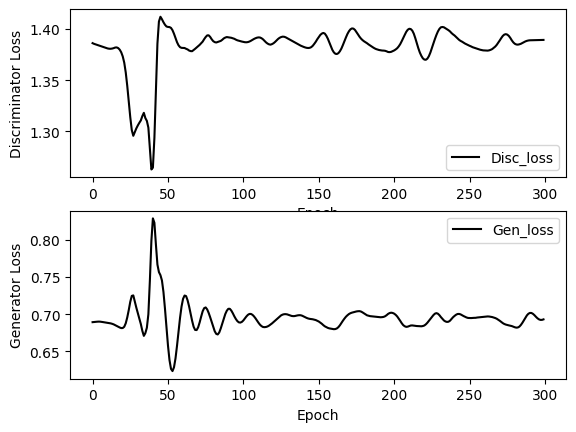

In [117]:
predicted_price, real_price, RMSPE = train(X_train, y_train, yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)

In [118]:
test_generator = tf.keras.models.load_model(f'./models_gan//generator_V_{epochs-1}.h5')

Test RMSE:  85.33429435953205


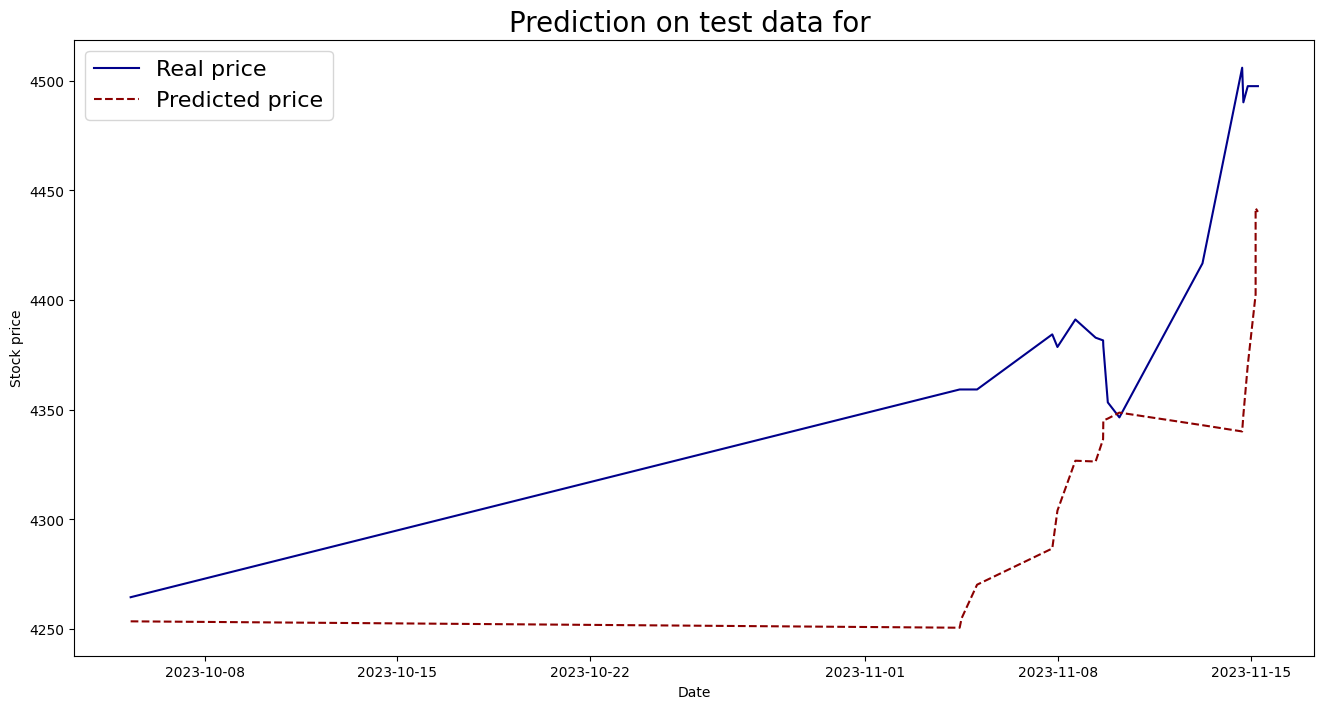

In [119]:
predicted_test_data = eval_op(test_generator, X_test)
plot_test_data(y_test, predicted_test_data,index_test)